In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simpson, cumulative_trapezoid
from imripy import constants as c, kepler, merger_system as ms, halo, inspiral, plot_utils as pu, waveform, detector
from imripy.inspiral import forces
from imripy.kepler import KeplerOrbit
import plotting
import copy
import common

This notebook explores isolated spikes, that means a central MBH with a DM spike around it.
It explores the phase space flow of $(a,e)$, shows an example inspiral, and calculates the dephasing and deshifting.

In [2]:
# Example System
m1 = 1e5 * c.solar_mass_to_pc
m2 = 10. * c.solar_mass_to_pc
D_l = 5e8 # 50 Mpc

hs = ms.HostSystem(m1, D_l=D_l)

In [3]:
from collections.abc import Sequence
issequence = lambda x: isinstance(x, Sequence)

# Isolated Spike

## Phase Space Flow

In [7]:
gw = forces.GWLoss()

# DM spikes
spike_73, df_73 = common.DMSpike(hs, 7./3.)
spike_32, df_32 = common.DMSpike(hs, 3./2.)

acc_73 = forces.AccretionLoss(halo=spike_73)
acc_32 = forces.AccretionLoss(halo=spike_32)


In [22]:
opt_32 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, df_32, acc_32])

opt_73 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, df_73, acc_73])

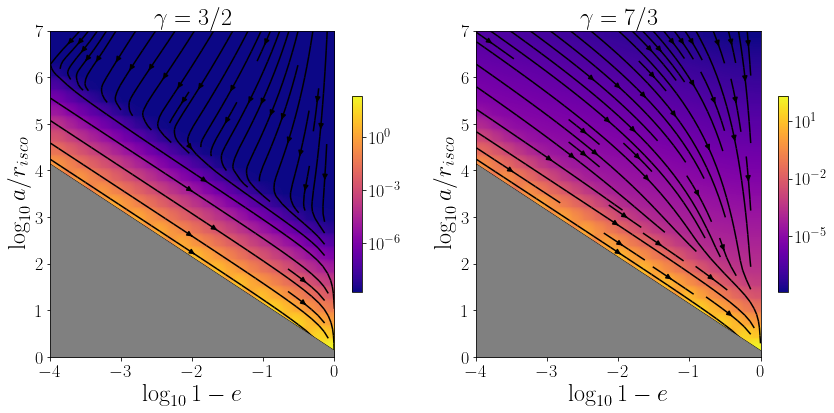

In [23]:
fig,axs = plt.subplots(1,2, figsize=(14,6))
a_grid = np.geomspace(hs.r_isco, 1e7*hs.r_isco, 25)
e_grid = 1.- np.geomspace(1e-4, 1., 25)

ko = KeplerOrbit(hs, m2, 0.)

im = pu.streamline(axs[0], hs, opt_32, ko, a_grid, e_grid)
axs[0].set_title(r"$\gamma=3/2$")
fig.colorbar(im, ax=axs[0], shrink=0.6)

im = pu.streamline(axs[1], hs, opt_73, ko, a_grid, e_grid)
axs[1].set_title(r"$\gamma=7/3$")
fig.colorbar(im, ax=axs[1], shrink=0.6)

for ax in axs:
    ax.set_xlabel(r"$\log_{10} 1-e$"); ax.set_ylabel(r"$\log_{10} a/r_{isco}$")
fig.savefig("plots/psf_iso.pdf", bbox_inches="tight")

## Example

In [9]:
a0 = 1e4 * hs.r_isco
e0 = 0.2  # low eccentricity
k0 = kepler.KeplerOrbit(hs, m2, a0, e0)

In [10]:
opt_gw = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw],
                                              periapsePrecession=True, accuracy=1e-11)

hs.halo = halo.ConstHalo(0.)
t_GW = 3.*2**(7./2)/85 * a0**4 * (1.-e0)**(7./2) / m1**2 / m2
ev_gw = inspiral.Classic.Evolve(hs, k0, t_fin = 2e1*t_GW, opt=opt_gw)

Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.2  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-11, with periapse precession
Required step size is less than spacing between numbers.
 -> Ended at 2.827e+00r_isco. Evolution took 0.3572s real time


In [11]:
# Unfortunately, the timescale involved are pretty large, and the resulting dephasing is numerical trash
# We can instead repeat the evolution from a later timepoint to get more accurate dephasings
index = np.argmax(ev_gw.a < 5e1*hs.r_isco)
k0_sec = ev_gw.get_kepler_orbit(index)
ev_gw_sec = inspiral.Classic.Evolve(hs, k0_sec, opt=opt_gw)

Evolving from  48.551405261429565  to  1.0 r_isco  with initial eccentricity 4.674089598955505e-05  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.1118s real time


In [12]:
opt_32 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, df_32],
                                                    periapsePrecession=True, accuracy=1e-11)

t_DF = np.abs(inspiral.Classic.E_orbit(hs, k0, opt=opt_32) / df_32.dE_dt(hs, k0, opt=opt_32))
hs.halo = spike_32

ev_32 = inspiral.Classic.Evolve(hs, k0, t_fin = 1e1*np.min([ev_gw.t[-1], t_DF]), opt=opt_32)

Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.2  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 92.2491s real time


In [13]:
index = np.argmax(ev_32.a < 5e1*hs.r_isco)
k0_sec = ev_32.get_kepler_orbit(index)
ev_32_sec = inspiral.Classic.Evolve(hs, k0_sec, t_fin = ev_32.t[-1]-ev_32.t[index], opt=opt_32)

Evolving from  49.48055816871781  to  1.0 r_isco  with initial eccentricity 0.005844724954449902  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 26.7505s real time


In [14]:
opt_73 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, df_73],
                                                    periapsePrecession=True, accuracy=1e-11)

hs.halo = spike_73
t_DF = np.abs(inspiral.Classic.E_orbit(hs, k0, opt=opt_73) / df_73.dE_dt(hs, k0, opt=opt_73))

ev_73 = inspiral.Classic.Evolve(hs, k0, t_fin = 1e1*np.min([ev_gw.t[-1], t_DF]), opt=opt_73)

Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.2  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 93.6210s real time


In [15]:
index = np.argmax(ev_73.a < 5e1*hs.r_isco)
k0_sec = ev_73.get_kepler_orbit(index)
ev_73_sec = inspiral.Classic.Evolve(hs, k0_sec, t_fin = ev_73.t[-1]-ev_73.t[index], opt=opt_73)

Evolving from  49.22448385613397  to  1.0 r_isco  with initial eccentricity 0.10137711173529469  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 30.0605s real time


In [16]:
ev_gw.f = np.sqrt(ev_gw.m_tot/ev_gw.a**3) / 2. / np.pi
ev_32.f = np.sqrt(ev_32.m_tot/ev_32.a**3) / 2. / np.pi
ev_73.f = np.sqrt(ev_73.m_tot/ev_73.a**3) / 2. / np.pi

ev_gw.N = cumulative_trapezoid(ev_gw.f, ev_gw.t, initial=0)
ev_32.N = cumulative_trapezoid(ev_32.f, ev_32.t, initial=0)
ev_73.N = cumulative_trapezoid(ev_73.f, ev_73.t, initial=0)

/media/data/Documents/PhD/imripy/src/imripy/waveform.py:141: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  mean_anomaly = 2.*np.pi*  np.cumsum([quad(F_interp, ev.t[i-1], ev.t[i], epsabs=acc, epsrel=acc, limit=200)[0] if i > 0 else 0. for i in range(len(ev.t))])
/media/data/Documents/PhD/imripy/src/imripy/waveform.py:141: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  mean_anomaly = 2.*np.pi*  np.cumsum([quad(F_interp, ev.t[i-1], ev.t[i], epsabs=acc, epsrel=acc, limit=200)[0] if i > 0 else 0. for i in range(len(ev.t))])


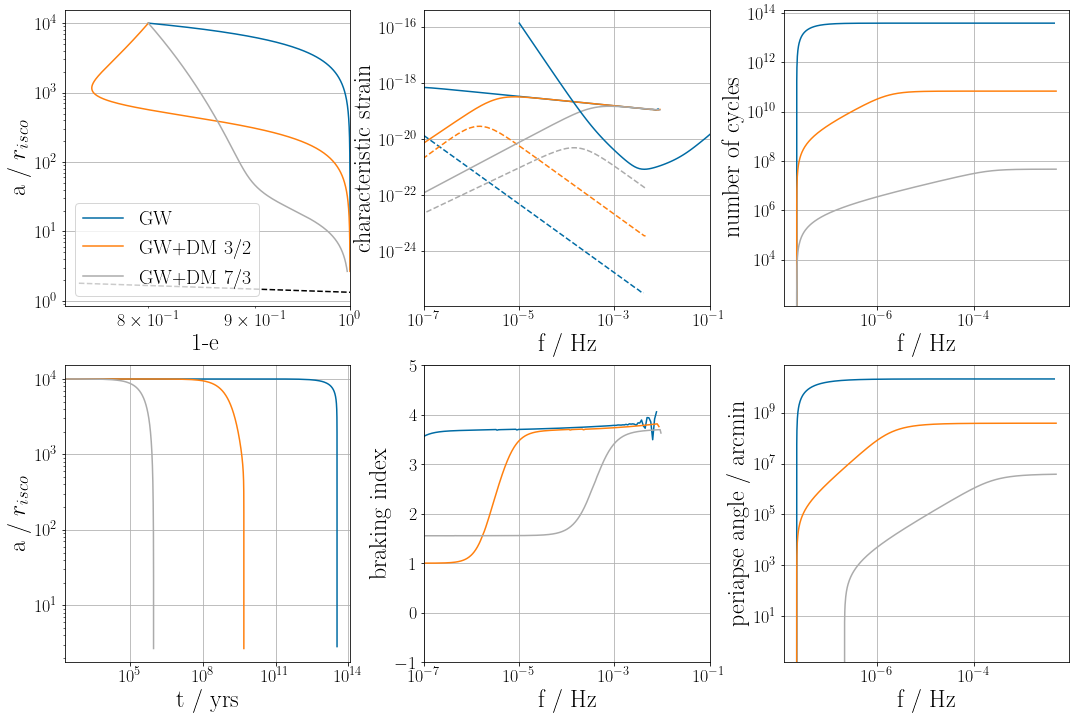

In [20]:
fig, axs = plt.subplots(2,3, figsize=(18,12))

l0=pu.plotEvolution(hs, ev_gw, ax_1mea=axs[0,0], ax_a=axs[1,0], ax_n=axs[1,1], label='GW')
l1=pu.plotEvolution(hs, ev_32, ax_1mea=axs[0,0], ax_a=axs[1,0], ax_n=axs[1,1], label='GW+DM 3/2')
l2=pu.plotEvolution(hs, ev_73, ax_1mea=axs[0,0], ax_a=axs[1,0], ax_n=axs[1,1], label='GW+DM 7/3')

pu.plotGWcharacteristicStrain(hs, ev_gw, axs[0,1], harmonics=[2,1], color=l0.get_c())
axs[0,2].loglog(ev_gw.f / c.hz_to_invpc, ev_gw.N, color=l0.get_c())
axs[1,2].loglog(ev_gw.f / c.hz_to_invpc, ev_gw.periapse_angle, color=l0.get_c())

pu.plotGWcharacteristicStrain(hs, ev_32, axs[0,1], harmonics=[2,1], color=l1.get_c())
axs[0,2].loglog(ev_32.f / c.hz_to_invpc, ev_32.N, color=l1.get_c())
axs[1,2].loglog(ev_32.f / c.hz_to_invpc, ev_32.periapse_angle, color=l1.get_c())


pu.plotGWcharacteristicStrain(hs, ev_73, axs[0,1], harmonics=[2,1], color=l2.get_c())
axs[0,2].loglog(ev_73.f / c.hz_to_invpc, ev_73.N, color=l2.get_c())
axs[1,2].loglog(ev_73.f / c.hz_to_invpc, ev_73.periapse_angle, color=l2.get_c())


e_grid = 1.-np.array(axs[0,0].get_xlim())
axs[0,0].plot(1.-e_grid, 8./6./(1.-e_grid), linestyle='--', color='black'); axs[0,0].legend(loc='lower left'); 

axs[0,0].set_xlim(right=1.); axs[0,0].set_xlabel("1-e"); axs[0,0].set_ylabel("a / $r_{isco}$")

f_gw = np.geomspace(detector.Lisa().Bandwith()[0], detector.Lisa().Bandwith()[1], 100)
axs[0,1].loglog(f_gw/c.hz_to_invpc, detector.Lisa().NoiseStrain(f_gw), label='LISA')
axs[0,1].set_xlabel("f / Hz"); axs[0,1].set_ylabel("characteristic strain")
axs[0,1].set_xlim(left=1e-7, right=1e-1)

axs[1,0].set_xlabel("t / yrs")
axs[1,0].set_ylabel("a / $r_{isco}$")

axs[1,1].set_xlabel("f / Hz")
axs[1,1].set_ylabel("braking index")
axs[1,1].set_ylim(-1, 5)
axs[1,1].set_xlim(axs[0,1].get_xlim())
axs[1,1].set_xscale('log')

axs[0,2].set_xlabel("f / Hz")
axs[0,2].set_ylabel("number of cycles")

axs[1,2].set_xlabel("f / Hz")
axs[1,2].set_ylabel("periapse angle / arcmin")

for ax in axs.flatten():
    ax.grid()
fig.subplots_adjust(wspace=0.26)
fig.savefig(f"plots/ev_iso_{m1/c.solar_mass_to_pc:.1e}.pdf", bbox_inches="tight")

In [18]:
dE_df_32 = common.energy_loss(hs, ev_32, df_32, opt_32)
r_df_32 = dE_df_32 / spike_32.potentialEnergy(spike_32.r_spike)
print(dE_df_32, r_df_32) # feedback ratio

-6.930936960572654e-17 16.884551147568224


In [19]:
dE_df_73 = common.energy_loss(hs, ev_73, df_73, opt_73)
r_df_73 = dE_df_73 / spike_73.potentialEnergy(spike_73.r_spike)
print(dE_df_73, r_df_73)

-1.9993678442512156e-15 0.7162986503743479


## Dephasing and Deshifting

In [18]:
def timescales(hs, k0, df=None, opt=None):
    """
    Estimates timescales for the inspirals
    """
    a0 = k0.a; e0 = k0.e; m1=hs.m1; m2=k0.m2; 
    t_GW = 3.*2**(7./2)/85 * a0**4 * (1.-e0)**(7./2) / m1**2 / m2
    
    if not df is None:
        t_DF = np.abs(inspiral.Classic.E_orbit(hs, k0, opt=opt) / df.dE_dt(hs, k0, opt=opt))
        return t_GW, t_DF
    return t_GW

In [33]:
def calc_dephasing(hss, df_base, df_compare, k0s, opts, hs_base=None, k0_base=None, opt_base=None, n=2):
    """
    Makes the inspirals with df_base and df_base+df_compare and calculates their dephasing and deshifting
    """
    if not issequence(hss):
        hss = [copy.deepcopy(hss) for i in range(len(df_compare))]  # careful to make actual copies and not references
    if not issequence(k0s):
        k0s = [copy.deepcopy(k0s) for i in range(len(df_compare))]
    if not issequence(opts):
        opts = [copy.deepcopy(opts) for i in range(len(df_compare))]
    
    hs_base = hs_base or copy.deepcopy(hss[0])
    k0_base = k0_base or copy.deepcopy(k0s[0])
    opt_base = opt_base or copy.deepcopy(opts[0])
    opt_base.dissipativeForces = df_base
    for i, dfs in enumerate(df_compare):
        opts[i].dissipativeForces = df_base + dfs
    
    # Base case
    ts = np.array(timescales(hs_base, k0_base))
    print(ts)
    ev_base = inspiral.Classic.Evolve(hs_base, k0_base, t_fin=1e2*np.min(ts), opt=opt_base)
    ev_base.f_gw, ev_base.N = waveform.N_cycles_n(2, hs_base, ev_base)
    _, ev_base.h_2p, ev_base.h_2c, __ = waveform.h_n(2, hs_base, ev_base)
    ev_base.f_orbit, ev_base.h_1p, ev_base.h_1c, __ = waveform.h_n(1, hs_base, ev_base)
    N_0interp = interp1d(ev_base.f_gw, ev_base.N, kind='cubic', bounds_error=False, fill_value=(0.,0.))
    pa_base = interp1d(ev_base.f_gw, ev_base.periapse_angle - ev_base.periapse_angle[-1], kind='cubic', 
                           bounds_error=False, fill_value=(0.,0.))

    # Compare cases
    evs = [ev_base]
    for i,(hs, k0, opt) in enumerate(zip(hss, k0s, opts)):
        ts = np.array(timescales(hs_base, k0_base, opt.dissipativeForces[-1], opt))
        print(i, ts)
        ev = inspiral.Classic.Evolve(hs, k0, t_fin=1e1*np.min(ts), opt=opt)
        ev.f_gw, ev.N = waveform.N_cycles_n(2, hs, ev)
        ev.dN = ev.N - N_0interp(ev.f_gw)
        _, ev.h_2p, ev.h_2c, __ = waveform.h_n(2, hs, ev)
        ev.f_orbit, ev.h_1p, ev.h_1c, __ = waveform.h_n(1, hs, ev)
        ev.dpa = np.abs((ev.periapse_angle - ev.periapse_angle[-1]) - pa_base(ev.f_gw))
        evs.append(ev)
    return evs

In [34]:
def compare_different_m1(m1, m2, D_l, acc=1e-11):
    """
    Makes an m1 system with and without spikes to compare them
    """
    hs_base = ms.HostSystem(m1, D_l=D_l)
    # GW loss
    #environmental effects
    gw = inspiral.forces.GWLoss()
    spike_73, df_73 = common.DMSpike(hs_base, 7./3.)
    spike_32, df_32 = common.DMSpike(hs_base, 3./2.)
    
    # base
    df_base = [gw]
    opt_base = inspiral.Classic.EvolutionOptions(dissipativeForces=df_base, periapsePrecession=True, accuracy=acc)
    # different hs for different mass precession
    hs_32 = copy.deepcopy(hs_base); hs_73 = copy.deepcopy(hs_base); 
    hs_32.halo =  spike_32; hs_73.halo = spike_73
    # initial orbit
    a0 = 1e2 * hs_base.r_isco
    e0 = 0.1
    k0_base = kepler.KeplerOrbit(hs_base, m2, a0, e0)
    # calc dephasing
    evs = calc_dephasing([hs_32, hs_73], df_base, [[df_32], [df_73]], k0s=k0_base, opts=opt_base, hs_base=hs_base)
    # feedback ratio
    evs[1].r_df = common.energy_loss(evs[1].hs, evs[1], evs[1].options.dissipativeForces[-1], evs[1].options) / spike_32.potentialEnergy(spike_32.r_spike)
    evs[2].r_df = common.energy_loss(evs[2].hs, evs[2], evs[2].options.dissipativeForces[-1], evs[2].options) / spike_73.potentialEnergy(spike_73.r_spike)
    
    return evs

In [35]:
evs_iso_m1e6 = compare_different_m1(1e6*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc, 5e8)

171791762.66529837
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.2834s real time
0 [1.71791763e+08 5.31273677e+09]
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 95.3148s real time
1 [1.71791763e+08 1.61853211e+05]
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 97.2649s real time


In [36]:
evs_iso_m1e5 = compare_different_m1(1e5*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc, 5e8)

1717917.6266529837
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.4908s real time
0 [1.71791763e+06 5.28291056e+08]
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 95.5255s real time
1 [1717917.62665298    5035.25828745]
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 78.3634s real time


In [37]:
evs_iso_m1e4 = compare_different_m1(1e4*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc, 5e8)

17179.17626652984
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.3339s real time
0 [1.71791763e+04 5.39336586e+07]
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 81.0673s real time
1 [17179.17626653   163.39841018]
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 78.8033s real time


In [38]:
evs_iso_m1e3 = compare_different_m1(1e3*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc, 5e8)

171.79176266529845
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.3263s real time
0 [1.71791763e+02 5.73566147e+06]
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 81.8613s real time
1 [171.79176267   5.68563535]
Evolving from  100.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11, with periapse precession
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 80.1923s real time


In [ ]:
evs_iso_m2e1 = compare_different_m1(1e5*c.solar_mass_to_pc, 1e1*c.solar_mass_to_pc, 5e8)

In [39]:
def plot_observable_dephasing(ax, evs, labels, ax_di=None, min_dN=10.):
    Lisa = detector.Lisa()
    bw = Lisa.Bandwith()
    
    for i, ev in enumerate(evs):
        observable = ( (ev.f_gw > bw[0]) &  (ev.f_gw < bw[1]) & 
                                  (2.*ev.f_gw*ev.h_2p > Lisa.NoiseStrain(ev.f_gw)))[:-1]
        
        nobservable = np.where(np.logical_not(observable))[0]
        observable = np.where(observable)[0]
    
        
        if np.any(nobservable[1:] != (nobservable[:-1]+1)): # there is a gap
            lgap = np.argmax(nobservable[1:] != (nobservable[:-1]+1))
            rgap = len(nobservable)-1- np.argmax(nobservable[::-1][1:] != (nobservable[::-1][:-1]-1))
            l, = ax.loglog(ev.f_gw[nobservable[:lgap]]/c.hz_to_invpc, np.abs(ev.dN[nobservable[:lgap]]), 
                        linestyle= '--')
            l, = ax.loglog(ev.f_gw[nobservable[rgap:]]/c.hz_to_invpc, np.abs(ev.dN[nobservable[rgap:]]), 
                        linestyle= '--', color=l.get_c())
        else:
            l, = ax.loglog(ev.f_gw[nobservable]/c.hz_to_invpc, np.abs(ev.dN[nobservable]), 
                        linestyle= '--')
            
        l, = ax.loglog(ev.f_gw[observable]/c.hz_to_invpc, np.abs(ev.dN[observable]), 
                       label=labels[i], linestyle='-', color=l.get_c())
        print(labels[i], ev.r_df)
        l, f5yrs = pu.plotLastTyears(ev.hs, ev, ax, color=l.get_c(), marker='p', 
                                     y=interp1d(ev.f_gw, np.abs(ev.dN)))
        
        if ax_di is not None:
            ddN_df = np.gradient(ev.dN, ev.f_gw)
            stop = np.where(np.abs(ev.dN) < min_dN)[0]
            stop = stop[0] if len(stop) > 0 else len(ddN_df)
            ax_di.plot(ev.f_gw[:stop]/c.hz_to_invpc, (ddN_df/ev.dN * ev.f_gw)[:stop], color=l.get_c())
        

$m_1=10^5M_\odot, \gamma=3/2$ 0.02901336605303877
$m_1=10^5M_\odot, \gamma=7/3$ 0.5760148037553874
$m_1=10^4M_\odot, \gamma=3/2$ 0.11645680725540908
$m_1=10^4M_\odot, \gamma=7/3$ 9.011943957048445
$m_1=10^3M_\odot, \gamma=3/2$ 0.4427441974614878
$m_1=10^3M_\odot, \gamma=7/3$ 125.43244154417259


<ipython-input-39-e7278b83cb60>:34: RuntimeWarning: divide by zero encountered in divide
  ax_di.plot(ev.f_gw[:stop]/c.hz_to_invpc, (ddN_df/ev.dN * ev.f_gw)[:stop], color=l.get_c())


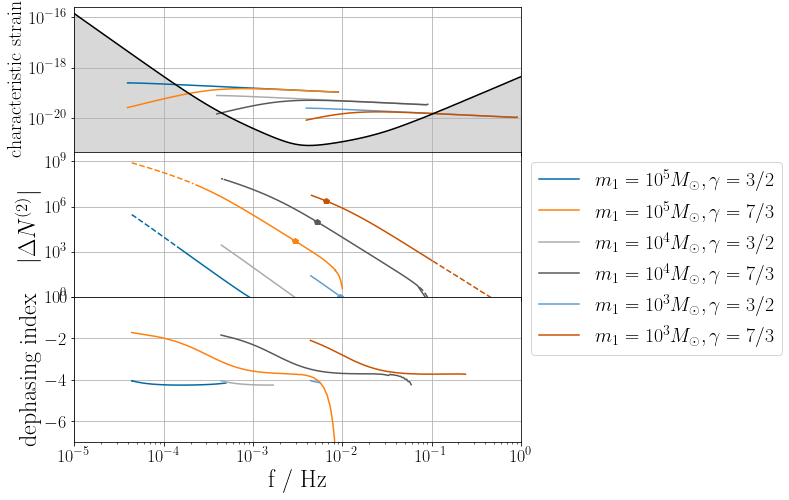

In [44]:
fig, axs = plt.subplots(3,1, sharex='all', figsize=(8,8))
Lisa = detector.Lisa()
f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
#for ev in evs_iso_m1e6[1:]:
#    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])
for ev in evs_iso_m1e5[1:]:
    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])
for ev in evs_iso_m1e4[1:]:
    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])
for ev in evs_iso_m1e3[1:]:
    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])

axs[0].loglog(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA', color='black')
axs[0].fill_between(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), color='gray', alpha=0.3)

#plot_observable_dephasing(axs[1], evs_iso_m1e6[1:], ["$m_1=10^6M_\odot, \gamma=3/2$", "$m_1=10^6M_\odot, \gamma=7/3$"],
#                         ax_di=axs[2])
plot_observable_dephasing(axs[1], evs_iso_m1e5[1:], ["$m_1=10^5M_\odot, \gamma=3/2$", "$m_1=10^5M_\odot, \gamma=7/3$"],
                         ax_di=axs[2])
plot_observable_dephasing(axs[1], evs_iso_m1e4[1:], ["$m_1=10^4M_\odot, \gamma=3/2$", "$m_1=10^4M_\odot, \gamma=7/3$"],
                         ax_di=axs[2])
plot_observable_dephasing(axs[1], evs_iso_m1e3[1:], ["$m_1=10^3M_\odot, \gamma=3/2$", "$m_1=10^3M_\odot, \gamma=7/3$"],
                         ax_di=axs[2])
for ax in axs:
    ax.grid()
axs[1].legend(bbox_to_anchor=(1.,1.), loc='upper left')
axs[1].set_ylim(bottom=1.); axs[1].set_xlim(left=1e-5, right=1)
axs[2].set_xlabel("f / Hz")
axs[1].set_ylabel("$|\Delta N^{(2)}|$")
axs[0].set_ylabel("characteristic strain",fontsize=20)
axs[2].set_ylabel("dephasing index")

axs[2].set_ylim(-7, 0)
fig.subplots_adjust(hspace=0.)
fig.savefig(f"plots/dephasing_iso_m2_10.pdf", bbox_inches="tight")

In [41]:
def plot_observable_deshifting(ax_d, evs, labels, ax_w = None, ax_ds=None, min_w=1.):
    Lisa = detector.Lisa()
    bw = Lisa.Bandwith()
    
    for i, ev in enumerate(evs):
        observable = ( (ev.f_gw > bw[0]) &  (ev.f_gw < bw[1]) & 
                                  (2.*ev.f_gw*ev.h_2p > Lisa.NoiseStrain(ev.f_gw)))[:-1]
        
        nobservable = np.where(np.logical_not(observable))[0]
        observable = np.where(observable)[0]
        
        if np.any(nobservable[1:] != (nobservable[:-1]+1)): # there is a gap
            lgap = np.argmax(nobservable[1:] != (nobservable[:-1]+1))
            rgap = len(nobservable)- np.argmax(nobservable[::-1][1:] != (nobservable[::-1][:-1]-1))
            l, = ax_d.loglog(ev.f_gw[nobservable[:lgap]]/c.hz_to_invpc, np.abs(ev.dpa[nobservable[:lgap]]), 
                        linestyle= '--')
            l, = ax_d.loglog(ev.f_gw[nobservable[rgap:]]/c.hz_to_invpc, np.abs(ev.dpa[nobservable[rgap:]]), 
                        linestyle= '--', color=l.get_c())
            if not ax_w is None:
                ax_w.loglog(ev.f_gw[nobservable[:lgap]]/c.hz_to_invpc, np.abs(ev.periapse_angle[nobservable[:lgap]]), 
                        linestyle= '--')
                ax_w.loglog(ev.f_gw[nobservable[rgap:]]/c.hz_to_invpc, np.abs(ev.periapse_angle[nobservable[rgap:]]), 
                        linestyle= '--', color=l.get_c())
        else:
            l, = ax_d.loglog(ev.f_gw[nobservable]/c.hz_to_invpc, np.abs(ev.dpa[nobservable]), 
                        linestyle= '--')
            if not ax_w is None:
                ax_w.loglog(ev.f_gw[nobservable]/c.hz_to_invpc, np.abs(ev.periapse_angle[nobservable]), 
                        linestyle= '--')
        
        l, = ax_d.loglog(ev.f_gw[observable]/c.hz_to_invpc, np.abs(ev.dpa[observable]), 
                       label=labels[i], linestyle='-', color=l.get_c())
        l, f5yrs = pu.plotLastTyears(ev.hs, ev, ax_d, color=l.get_c(), marker='p', 
                                     y=interp1d(ev.f_gw, np.abs(ev.dpa)))
        
        if not ax_w is None:
            ax_w.loglog(ev.f_gw[observable]/c.hz_to_invpc, np.abs(ev.periapse_angle[observable]), 
                       label=labels[i], linestyle='-', color=l.get_c())
            l, f5yrs = pu.plotLastTyears(ev.hs, ev, ax_w, color=l.get_c(), marker='p', 
                                     y=interp1d(ev.f_gw, np.abs(ev.periapse_angle)))

        if ax_ds is not None:
            ddpa_df = np.gradient(ev.dpa, ev.f_gw)
            stop = np.where(np.abs(ev.dpa) < min_w)[0]
            stop = stop[0] if len(stop) > 0 else len(ddpa_df)
            ax_ds.plot(ev.f_gw[:stop]/c.hz_to_invpc, (ddpa_df/ev.dpa * ev.f_gw)[:stop], color=l.get_c())
            #ax_ds.plot(ev.f_gw/c.hz_to_invpc, (ddpa_df/ev.dpa * ev.f_gw), color=l.get_c())

<ipython-input-41-915aff4e46f4>:46: RuntimeWarning: divide by zero encountered in divide
  ax_ds.plot(ev.f_gw[:stop]/c.hz_to_invpc, (ddpa_df/ev.dpa * ev.f_gw)[:stop], color=l.get_c())


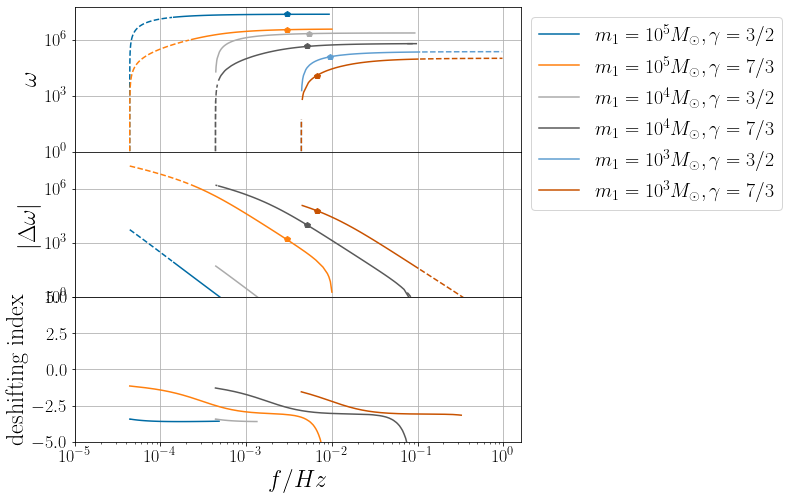

In [45]:
fig, axs = plt.subplots(3,1, sharex='all', figsize=(8,8))
plot_observable_deshifting(axs[1], evs_iso_m1e5[1:], ["$m_1=10^5M_\odot, \gamma=3/2$", "$m_1=10^5M_\odot, \gamma=7/3$"], 
                               ax_w=axs[0], ax_ds=axs[2])
plot_observable_deshifting(axs[1], evs_iso_m1e4[1:], ["$m_1=10^4M_\odot, \gamma=3/2$", "$m_1=10^4M_\odot, \gamma=7/3$"], 
                               ax_w=axs[0], ax_ds=axs[2])
plot_observable_deshifting(axs[1], evs_iso_m1e3[1:], ["$m_1=10^3M_\odot, \gamma=3/2$", "$m_1=10^3M_\odot, \gamma=7/3$"], 
                               ax_w=axs[0], ax_ds=axs[2])

for ax in axs:
    ax.grid()
    ax.set_ylim(bottom=1); ax.set_xlim(left=1e-5)

axs[0].set_ylabel("$\omega$")
axs[1].set_ylabel("$|\Delta \omega|$")
axs[2].set_ylabel("deshifting index")
axs[2].set_xlabel("$f / Hz$")
axs[0].legend(bbox_to_anchor=(1.,1.), loc='upper left') 
axs[2].set_ylim(-5, 5)

fig.subplots_adjust(hspace=0.)
fig.savefig(f"plots/deshifting_iso_m2_10.pdf", bbox_inches="tight")

In [ ]:
def recompute_from_loaded(evs):
    """
    In case the runs were saved to file, recomputes the dephasing and deshifting
    """
    evs[0].f_gw, evs[0].N = waveform.N_cycles_n(2, hs, evs[0])
    #_, evs[0].h_2p, ev_base.h_2c, __ = waveform.h_n(2, hs_base, ev_base)
    #ev_base.f_orbit, ev_base.h_1p, ev_base.h_1c, __ = waveform.h_n(1, hs, ev_base)
    N_0interp = interp1d(evs[0].f_gw, evs[0].N, kind='cubic', bounds_error=False, fill_value=(0.,0.))
    pa_base = interp1d(evs[0].f_gw, evs[0].periapse_angle - evs[0].periapse_angle[-1], kind='cubic',
                           bounds_error=False, fill_value=(0.,0.))

    for i in range(1,len(evs)):
        evs[i].f_gw, evs[i].N = waveform.N_cycles_n(2, hs, evs[i])
        evs[i].dN = evs[i].N - N_0interp(evs[i].f_gw)
        #_, evs[i].h_2p, evs[i].h_2c, __ = waveform.h_n(2, hs, evs[i])
        #evs[i].f_orbit, ev.h_1p, ev.h_1c, __ = waveform.h_n(1, hs, evs[i])
        evs[i].dpa = np.abs((evs[i].periapse_angle - evs[i].periapse_angle[-1]) - pa_base(evs[i].f_gw))

recompute_from_loaded(evs_iso_m1e3)
recompute_from_loaded(evs_iso_m1e4)
recompute_from_loaded(evs_iso_m1e5)